In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
import random

## General classes

In [22]:
class Environment:
    def __init__(self):
        pass

    def round(self, product_price):
        pass

In [23]:
class Agent:
    def __init__(self):
        pass

    def pull_arm(self):
        pass

    def update(self, reward_t):
        pass

### Requirement 1: single product and stochastic environment

#### Environment

In [24]:
class SingleProductEnvironment(Environment):
  def __init__(self, T, valuation_distr=stats.uniform):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = valuation_distr.rvs(size=T)

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

#### Agent without inventory constraint - UCB1

In [25]:
class UCB1(Agent):
    def __init__(self, T, prices, range=1):
        self.range = range # Range of the reward
        self.P = len(prices) # Prices' set cardinality
        self.T = T # Number of rounds
        self.pi_t = None # Init price

        self.average_rewards = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)

        self.t = 0 # Starting round

    def pull_arm(self):
        # Check if the round is less then number of prices
        if self.t < self.P:
            # then set it as product_price
            self.pi_t = self.t
        else:
            # Compute UCB1
            ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls)

            # Extract the price that maximizes the UCB1
            self.pi_t = np.argmax(ucbs)

        return self.pi_t

    def update(self, reward):
        self.N_pulls[self.pi_t] += 1

        # As average, we have (total purchasing) / (number of times of purchasing)
        self.average_rewards[self.pi_t] += (reward - self.average_rewards[self.pi_t])/self.N_pulls[self.pi_t]
        self.t += 1

#### Clairvoyant without inventory constraint

In [26]:
class SingleProductStochasticClairvoyant:
    def __init__(self, T, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [27]:
# Parameters
T = 10000

# Prices
max_price = 1
price_step = T ** (-1/3)
prices = np.arange(0, max_price, price_step)

# Valuation prob. distribution
max_valuation = 1
#valuation_distr = stats.binom(loc=0, n=max_valuation, p=0.5)
valuation_distr = stats.uniform(loc=0, scale=max_price)

In [28]:
# Run clairvoyant
clairvoyant = SingleProductStochasticClairvoyant(T, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T, valuation_distr)
  ucb_like_agent = UCB1(T, prices, range=max_price)

  agent_rewards = []

  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)

  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

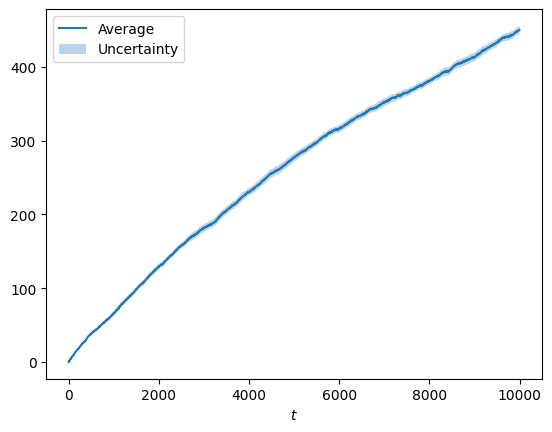

In [29]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

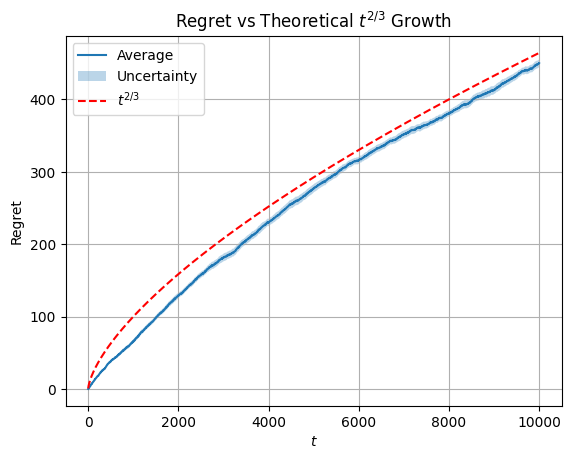

In [30]:
average_regret = regret_per_trial.mean(axis=0)  # media
regret_sd = regret_per_trial.std(axis=0)        # deviazione standard

t = np.arange(1, T+1)  # inizia da 1 per evitare t^{2/3} = 0^{2/3} = 0
regret_theory = t**(2/3)

plt.plot(t, average_regret, label="Average")
plt.fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.plot(t, regret_theory, label=r"$t^{2/3}$", linestyle='--', color='red')

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.legend()
plt.title("Regret vs Theoretical $t^{2/3}$ Growth")
plt.grid(True)
plt.show()

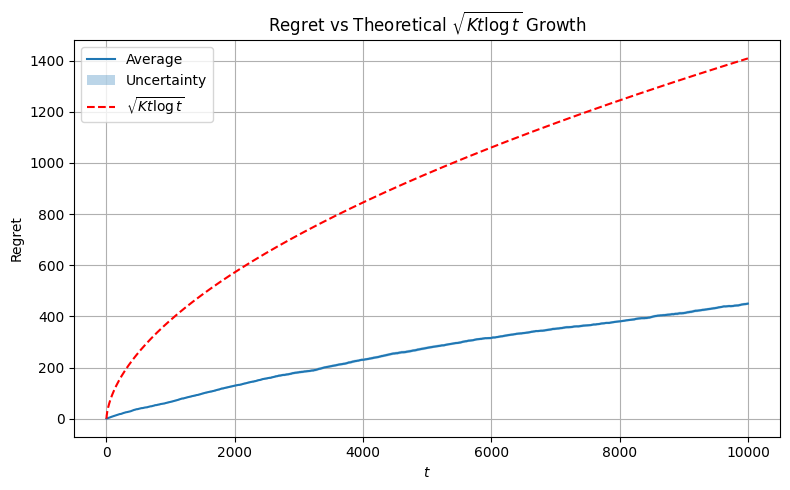

In [31]:
K= 1/price_step
t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = np.sqrt(K * t * np.log(t))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)

# Aggiunta curva asintotica
plt.plot(t - 1, theoretical_curve, label=r"$\sqrt{K t \log t}$", linestyle="--", color="red")

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical $\sqrt{K t \log t}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Agent with inventory constraint - UCB-like

In [32]:
class UCBLike():
    def __init__(self, T, B, prices, range=1):
        self.T = T
        self.P = len(prices)
        self.range = range

        self.pi_t = None
        self.avg_f = np.zeros(self.P)
        self.avg_c = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)
        self.budget = B

        self.t = 0

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            self.pi_t = 0
            return 0

        if self.t < self.P:
            self.pi_t = self.t
        else:
            # Upper Confidence Bound
            f_ucbs = self.avg_f + self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Lower Confidence Bound
            c_lcbs = self.avg_c - self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Price optimal distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)

            # Set current price
            self.pi_t = np.random.choice(self.P, p=gamma_t)

        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1
            return gamma

        c = -f_ucbs

        A_ub = [c_lcbs]
        rho = self.budget/self.T
        b_ub = [rho]

        A_eq = [np.ones(self.P)]
        b_eq = [1]

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))

        gamma = res.x
        return gamma

    def update(self, f_t, c_t):
        # Update the number of pulled price
        self.N_pulls[self.pi_t] += 1

        # Update averages
        self.avg_f[self.pi_t] = self.avg_f[self.pi_t] + (f_t - self.avg_f[self.pi_t])/self.N_pulls[self.pi_t]
        self.avg_c[self.pi_t] = self.avg_c[self.pi_t] + (c_t - self.avg_c[self.pi_t])/self.N_pulls[self.pi_t]

        # Update budget
        self.budget = self.budget - c_t

        self.t += 1

#### Clairvoyant with inventory constraint

In [33]:
class SingleProductStochasticInventoryClaivoyant:
    def __init__(self, T, budget, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices
        self.budget = budget

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        A_ub = [selling_prob]
        rho = self.budget/self.T
        b_ub = [rho]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0, 1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [15]:
# Parameters
T = 10000
B = T * 3/4

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)

# Valuation prob. distribution
max_valuation = 1
valuation_distr = stats.uniform(loc=0, scale=max_price)

In [36]:
# Run clairvoyant
clairvoyant = SingleProductStochasticInventoryClaivoyant(T, B, prices, valuation_distr)

expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 20
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T)
  ucb_like_agent = UCBLike(T, B, prices, range=max_price)

  agent_rewards = []
  for t in range(T):
    if(B<=0):
      break
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t, r_t > 0)

    agent_rewards.append(r_t)
    if(r_t>0):
      B = B - 1

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

TypeError: bad operand type for unary -: 'NoneType'

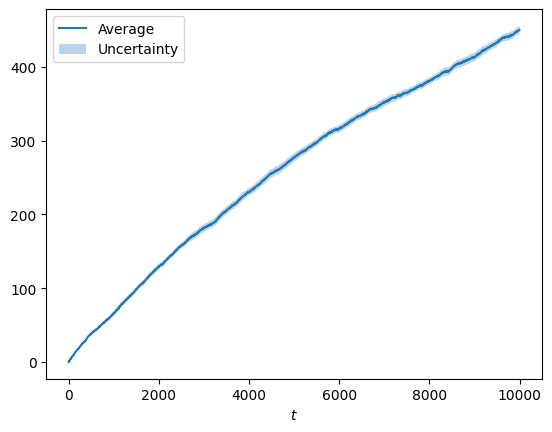

In [35]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

In [37]:
ucb_like_agent.budget

AttributeError: 'UCB1' object has no attribute 'budget'

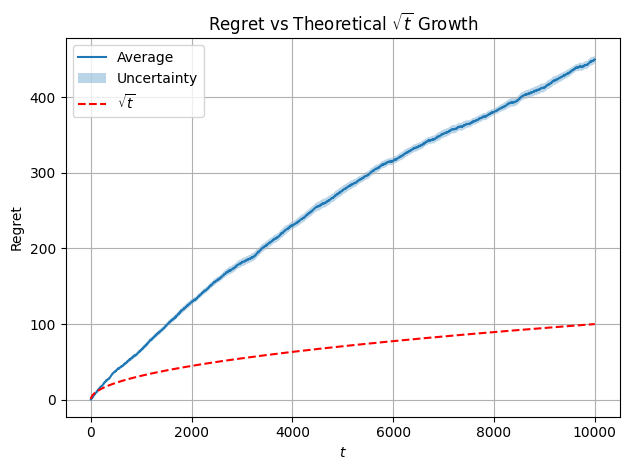

In [38]:
t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = np.sqrt(t)
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)


plt.plot(t - 1, theoretical_curve, label=r"$\sqrt{t }$", linestyle="--", color="red")


plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical $\sqrt{ t}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Requirement 2: multiple products and stochastic environment

In [39]:
class MultipleProductEnvironment(Environment):
  def __init__(self, T, N, max_valuation):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer

    # Valuation of each buyer sampled from the given distribution function
    self.valuations = np.random.uniform(0, max_valuation, size=(T, N))

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

### Requirement 3: best-of-both-worlds algorithms with a single product

In [148]:
def getDistribution():
    arr = np.arange(0.2, 2, 0.2)
    random_index_a = random.randint(0, len(arr) - 1)
    random_index_b = random.randint(0, len(arr) - 1)

    return stats.beta(arr[random_index_a], arr[random_index_b])

In [196]:
def getDistribution():
    a = stats.uniform(loc=0, scale=2).rvs()
    b = stats.uniform(loc=0, scale=2).rvs()

    return stats.beta(a,b)

In [197]:
class SingleProductHighlyNonStationaryEnvironment(Environment):
  def __init__(self, T, valuation_distr):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    #self.valuation = valuation_distr.rvs(size=T)
    self.valuation = [valuation_distr[i].rvs() for i in range(T)]

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

In [198]:
class SingleProductHighltyNonStationaryClairvoyant:
    def __init__(self, T, B, prices, valuation_distr):
        self.T = T
        self.prices = prices
        self.B=B
        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product

        selling_prob = [1 - self.valuation_distr[i].cdf(self.prices) for i in range(T)]
        selling_prob_mean=np.mean(selling_prob, axis=0)

        ## Liner programming
        c = - self.prices * selling_prob_mean # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        A_ub = [selling_prob_mean]
        rho=self.B/self.T
        b_ub = [rho]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0,1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

In [199]:
class EXP3Agent(Agent):
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [201]:
# Parameters
T = 20000
B = T * 3/4

# Prices
max_price = 1.1
price_step = 0.1
prices = np.arange(0.1, max_price, price_step)

# Valuation prob. distribution
max_valuation = 1

In [202]:
prices

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [203]:
learning_rate = np.sqrt(np.log(K)/(K*T))
eta=1/np.sqrt(T)

valuation_distributions= [getDistribution() for _ in range(T)]
selling_prob = [1 - valuation_distributions[i].cdf(prices) for i in range(T)]
selling_prob_mean=np.mean(selling_prob, axis=0)

In [204]:
class FFMultiplicativePacingAgent(Agent):
    def __init__(self, prices_set, budget, T, eta, learning_rate):
        self.prices_set = prices_set
        self.K = len(prices_set)
        self.learning_rate = learning_rate
        self.exp3 = EXP3Agent(self.K, self.learning_rate)
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0
        self.N_pulls = np.zeros(len(prices_set))
        self.price_index = 0

    def pull_arm(self):
        if self.budget < 1:
            self.price_index = 0
            return 0
        self.price_index = self.exp3.pull_arm()
        return self.prices_set[self.price_index]

    def update(self, f_t):
        c_t = int(f_t > 0) # >=
        L = f_t - self.lmbd*(c_t-self.rho)

        L_up = 1 -(1/self.rho)*(-self.rho)
        L_low = 0 -(1/self.rho)*(1-self.rho)
        rescaled_L = (L - L_low)/(L_up-L_low)
        self.exp3.update(1 -rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t
        # log
        self.N_pulls[self.price_index] += 1

    def get_budget(self):
      return self.budget

In [205]:
prices_arr = []
rewards = []

# Run clairvoyant
clairvoyant = SingleProductHighltyNonStationaryClairvoyant(T, B, prices, valuation_distributions)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 30
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductHighlyNonStationaryEnvironment(T, valuation_distributions)
  multiplicative_pacing_agent = FFMultiplicativePacingAgent(prices, B, T, eta, learning_rate)
  count = 0
  agent_rewards = []
  for t in range(T):
    if(count>=B):
      break
    # This returns the price index
    #pi_t = multiplicative_pacing_agent.pull_arm()
    # Get the actual price
    p_t = multiplicative_pacing_agent.pull_arm()
    # Get reward
    r_t = env.round(p_t)

    prices_arr.append(p_t)
    rewards.append(r_t)

    # Update agent state
    multiplicative_pacing_agent.update(r_t)

    agent_rewards.append(r_t)
    if(r_t>0):
      count = count + 1

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

In [213]:
import numpy as np

# Array binario: 1 se diverso da 0, altrimenti 0
binario = [1 if x != 0 else 0 for x in rewards[:T]]

print(binario)


[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 

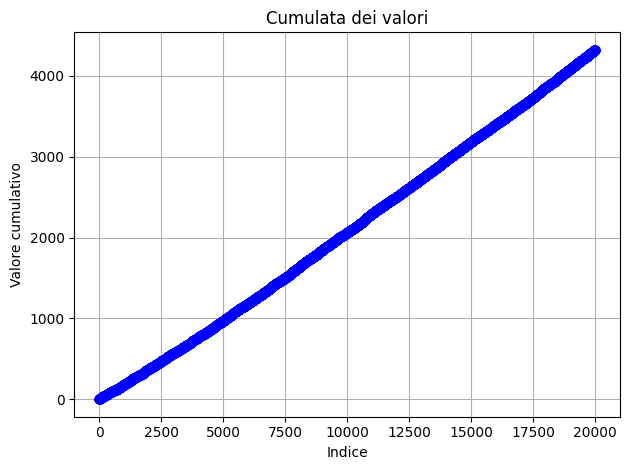

In [223]:
import numpy as np
import matplotlib.pyplot as plt


# Calcolo della somma cumulativa
cumulata = np.cumsum(rewards[:T])

# Plot
plt.plot(cumulata, marker='o', linestyle='-', color='blue')
plt.xlabel('Indice')
plt.ylabel('Valore cumulativo')
plt.title('Cumulata dei valori')
plt.grid(True)
plt.tight_layout()
plt.show()


In [142]:
prices_arr[:10]

[np.float64(0.2),
 np.float64(1.0),
 np.float64(0.2),
 np.float64(0.8),
 np.float64(0.1),
 np.float64(0.8),
 np.float64(0.4),
 np.float64(0.6),
 np.float64(0.8),
 np.float64(0.7000000000000001)]

In [143]:
set(prices_arr)

{np.float64(0.1),
 np.float64(0.2),
 np.float64(0.30000000000000004),
 np.float64(0.4),
 np.float64(0.5),
 np.float64(0.6),
 np.float64(0.7000000000000001),
 np.float64(0.8),
 np.float64(0.9),
 np.float64(1.0)}

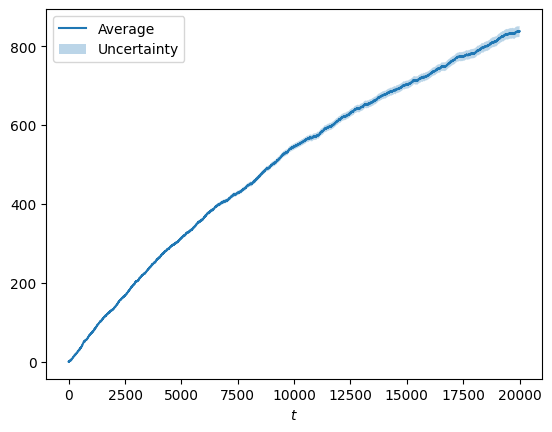

In [206]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

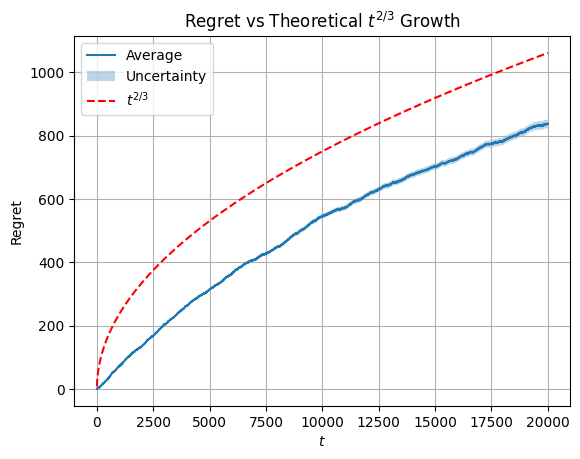

In [207]:
average_regret = regret_per_trial.mean(axis=0)  # media
regret_sd = regret_per_trial.std(axis=0)        # deviazione standard

t = np.arange(1, T+1)  # inizia da 1 per evitare t^{2/3} = 0^{2/3} = 0
regret_theory = (1300 / np.sqrt(30000*np.log(K))) * np.sqrt(t*np.log(K))

plt.plot(t, average_regret, label="Average")
plt.fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.plot(t, regret_theory, label=r"$t^{2/3}$", linestyle='--', color='red')

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.legend()
plt.title("Regret vs Theoretical $t^{2/3}$ Growth")
plt.grid(True)
plt.show()

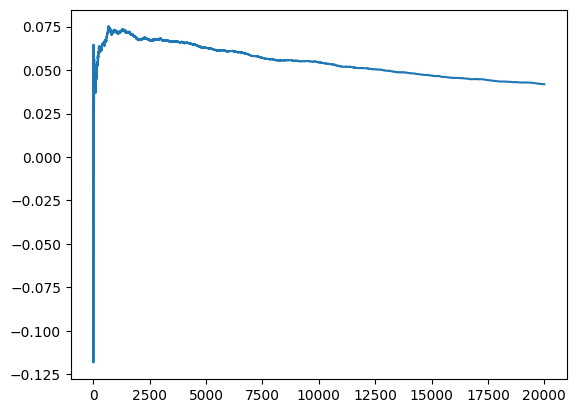

In [208]:
diff = average_regret / t
plt.plot(t, diff, label="andament")

In [209]:
multiplicative_pacing_agent.get_budget()

6295.0

### Requirement 4: best-of-both-worlds algorithms with multiple products

### Requirement 5: slightly non-stationary environments with multiple products